In [95]:
import json

with open('label_dict.json') as json_file:
    label_dict = json.load(json_file)

label_dict

{'Benign': 'Benign',
 'Botnet': 'Botnet',
 'Brute-force': 'Brute-force',
 'DDoS attack': 'DDoS attack',
 'DoS attack': 'DoS attack',
 'Infilteration': 'Infilteration',
 'Web attack': 'Web attack'}

In [96]:
import json

with open('class_weights.json') as json_file:
    class_weights = json.load(json_file)

class_weights

{'0': 0.2857142857142857,
 '1': 2.857142857142857,
 '2': 2.857142857142857,
 '3': 1.4285714285714286,
 '4': 1.4285714285714286,
 '5': 1.4285714285714286,
 '6': 1.4285714285714286}

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
import logging.config
from gym import  spaces
import gym
import json
import sys
import time
use_subset = True  # Set to False to use the full dataset
if use_subset:
    train_df = pd.read_csv("processed_data/train_df_subset.csv")
    test_df = pd.read_csv("processed_data/train_df_subset.csv")
else:
    train_df = pd.read_csv("processed_data/train_df.csv")
    test_df = pd.read_csv("processed_data/test_df.csv")

with open('processed_data/class_weights.json', 'r') as f:
    class_weights = json.load(f)
with open('processed_data/label_dict.json', 'r') as f:
    label_dict = json.load(f)

In [98]:
class data_cls:
    def __init__(self, train_test, attack_map, **kwargs):
        self.train_test = train_test
        
        if self.train_test == 'train':
            self.train_path = "train_df.csv"
        else:
            self.test_path = "test_df.csv"

        self.attack_map =   attack_map 
        self.attack_types = list(attack_map.keys())
        
        self.loaded = False
    
    def get_batch(self, batch_size=100):
        if not self.loaded:
            self._load_df()
        
        # Ensure batch_size does not exceed the DataFrame size
        if batch_size > self.data_shape[0]:
            raise ValueError(f"batch_size ({batch_size}) cannot be larger than the dataset size ({self.data_shape[0]}).")
        
        # Calculate wrapped indices using modulo
        indexes = [(self.index + i) % self.data_shape[0] for i in range(batch_size)]
        
        # Update the index for the next batch
        self.index = (self.index + batch_size) % self.data_shape[0]
        
        # Select the batch using iloc with valid indices
        batch = self.df.iloc[indexes]
        
        map_type = pd.Series(index=self.attack_types, data=np.arange(len(self.attack_types))).to_dict()
        labels = batch[label_col].map(self.attack_map).map(map_type).values
        del batch[label_col]
        
        return np.array(batch), labels
    
    def get_full(self):

        self._load_df()
        
        batch = self.df
        map_type = pd.Series(index=self.attack_types,data=np.arange(len(self.attack_types))).to_dict()
        labels = batch[label_col].map(self.attack_map).map(map_type).values
        
        del(batch[label_col])
        
        return np.array(batch), labels
    
    def get_shape(self):
        if self.loaded is False:
            self._load_df()
        
        self.data_shape = self.df.shape
        return self.data_shape
    
    def _load_df(self):
        if self.train_test == 'train':
            self.df = pd.read_csv(self.train_path) 
        else:
            self.df = pd.read_csv(self.test_path)
            
        self.index=np.random.randint(0,self.df.shape[0]-1,dtype=np.int32)
        self.loaded = True

In [99]:
class NetworkClassificationEnv(gym.Env, data_cls):
    def __init__(self,train_test, attack_map, **kwargs):
        data_cls.__init__(self,train_test, attack_map,**kwargs)
        self.data_shape = self.get_shape()
        self.batch_size = kwargs.get('batch_size', 1) 
        self.fails_episode = kwargs.get('fails_episode', 10) 
        
        # Gym spaces
        self.action_space = spaces.Discrete(len(self.attack_types))
        self.observation_space = spaces.Discrete(self.data_shape[0])
        
        self.observation_len = self.data_shape[1]-1
        
        self.counter = 0

    def _update_state(self):
        self.states,self.labels = self.get_batch(self.batch_size)
        

    def reset(self):
        self.states,self.labels = self.get_batch(self.batch_size)
        self.counter = 0
        
        return self.states
    
    def _get_rewards(self,actions):
        self.reward = 0
        if actions == self.labels:
            self.reward = 1
        else: 
            self.counter += 1

    def step(self,actions):
        self._get_rewards(actions)
            
        self._update_state()

        if self.counter >= self.fails_episode:
            self.done = True
        else:
            self.done = False
            
        return self.states, self.reward, self.done
    

In [100]:
import tensorflow as tf

def huber_loss(y_true, y_pred, clip_value=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < clip_value
    squared_loss = 0.5 * tf.square(error)
    linear_loss = clip_value * (tf.abs(error) - 0.5 * clip_value)
    return tf.where(is_small_error, squared_loss, linear_loss)

import keras.losses
keras.losses.huber_loss = huber_loss

In [101]:
class QNetwork():
    def __init__(self,obs_size,num_actions, hidden_dense_layer_dict = {"Dense_1": {"Size": 100}}, learning_rate=0.001):
        self.model = Sequential()
        
        self.model.add(Input(shape=(obs_size,)))

        for key, value in hidden_dense_layer_dict.items():
            self.model.add(Dense(value["Size"], activation='relu', name=key))

        self.model.add(Dense(num_actions))
        
        optimizer = optimizers.Adam(learning_rate)
        self.model.compile(loss=huber_loss,optimizer=optimizer)

    def predict(self,state,batch_size=1):
        return self.model.predict(state,batch_size=batch_size, verbose=0)

    def update(self, states, q):
        loss = self.model.train_on_batch(states, q, class_weight=class_weights)
        return loss

class Policy:
    def __init__(self, num_actions, estimator):
        self.num_actions = num_actions
        self.estimator = estimator
    
class Epsilon_greedy(Policy):
    def __init__(self,estimator ,num_actions,epsilon,decay_rate, epoch_length):
        Policy.__init__(self, num_actions, estimator)
        self.name = "Epsilon Greedy"
        if (epsilon is None or epsilon < 0 or epsilon > 1):
            print("EpsilonGreedy: Invalid value of epsilon", flush = True)
            sys.exit(0)
        self.epsilon = epsilon
        self.step_counter = 0
        self.epoch_length = epoch_length
        self.decay_rate = decay_rate
        self.epsilon_decay = True
        
    def get_actions(self,states):
        if np.random.rand() <= self.epsilon:
            actions = np.random.randint(0, self.num_actions,states.shape[0])
        else:
            self.Q = self.estimator.predict(states,states.shape[0])

            actions = []
            for row in range(self.Q.shape[0]):
                best_actions = np.argwhere(self.Q[row] == np.amax(self.Q[row]))
                actions.append(best_actions[np.random.choice(len(best_actions))].item())
            
        self.step_counter += 1 

        if self.epsilon_decay:
            if self.step_counter % self.epoch_length == 0:
                self.epsilon = max(.01, self.epsilon * self.decay_rate**self.step_counter)
            
        return actions

class Agent(object):   
    def __init__(self, actions, obs_size, policy="EpsilonGreedy", **kwargs):
        
        self.actions = actions
        self.num_actions = len(actions)
        self.obs_size = obs_size
        
        self.epsilon = kwargs.get('epsilon', 1)
        self.gamma = kwargs.get('gamma', 0.001)
        self.minibatch_size = kwargs.get('minibatch_size', 2)
        self.epoch_length = kwargs.get('epoch_length', 100)
        self.decay_rate = kwargs.get('decay_rate',0.99)
        self.exp_rep = kwargs.get('exp_rep',True)
        
        if self.exp_rep:
            self.memory = ReplayMemory(self.obs_size, kwargs.get('mem_size', 10))
        
        self.ddqn_time = 100
        self.ddqn_update = self.ddqn_time

        self.model_network = QNetwork(self.obs_size, 
                                      self.num_actions,
                                      kwargs.get('hidden_dense_layer_dict', {"Dense_1": {"Size": 100}}),
                                      kwargs.get('learning_rate', 0.001))
        
        self.target_model_network = QNetwork(self.obs_size, self.num_actions,
                                             kwargs.get('hidden_dense_layer_dict', {"Dense_1": {"Size": 100}}),
                                             kwargs.get('learning_rate', 0.001))
        
        self.target_model_network.model.set_weights(self.model_network.model.get_weights()) 
        
        if policy == "EpsilonGreedy":
            self.policy = Epsilon_greedy(self.model_network,
                                         len(actions),
                                         self.epsilon,
                                         self.decay_rate,
                                         self.epoch_length)
        
    def act(self,states):
        actions = self.policy.get_actions(states)
        return actions
    
    def learn(self, states, actions,next_states, rewards, done):
        if self.exp_rep:
            self.memory.observe(states, actions, rewards, done)
        else:
            self.states = states
            self.actions = actions
            self.next_states = next_states
            self.rewards = rewards
            self.done = done


    def update_model(self):
        if self.exp_rep:
            (states, actions, rewards, next_states, done) = self.memory.sample_minibatch(self.minibatch_size)
        else:
            states = self.states
            rewards = self.rewards
            next_states = self.next_states
            actions = self.actions
            done = self.done
            
        next_actions = []
        Q_prime = self.model_network.predict(next_states,self.minibatch_size)

        for row in range(Q_prime.shape[0]):
            best_next_actions = np.argwhere(Q_prime[row] == np.amax(Q_prime[row]))
            next_actions.append(best_next_actions[np.random.choice(len(best_next_actions))].item())
        sx = np.arange(len(next_actions))

        Q = self.target_model_network.predict(states,self.minibatch_size)

        targets = rewards.reshape(Q[sx,actions].shape) + \
                  self.gamma * Q_prime[sx,next_actions] * \
                  (1-done.reshape(Q[sx,actions].shape))   
        Q[sx,actions] = targets  
        
        loss = self.model_network.model.train_on_batch(states,Q)
        
        self.ddqn_update -= 1
        if self.ddqn_update == 0:
            self.ddqn_update = self.ddqn_time
            self.target_model_network.model.set_weights(self.model_network.model.get_weights()) 
        
        return loss    
    
        
class ReplayMemory(object):
    def __init__(self, observation_size, max_size):
        self.observation_size = observation_size
        self.num_observed = 0
        self.max_size = max_size
        self.samples = {
                 'obs'      : np.zeros(self.max_size * 1 * self.observation_size,
                                       dtype=np.float32).reshape(self.max_size, self.observation_size),
                 'action'   : np.zeros(self.max_size * 1, dtype=np.int16).reshape(self.max_size, 1),
                 'reward'   : np.zeros(self.max_size * 1).reshape(self.max_size, 1),
                 'terminal' : np.zeros(self.max_size * 1, dtype=np.int16).reshape(self.max_size, 1),
               }

    def observe(self, state, action, reward, done):
        index = self.num_observed % self.max_size
        self.samples['obs'][index, :] = state
        self.samples['action'][index, :] = action
        self.samples['reward'][index, :] = reward
        self.samples['terminal'][index, :] = done

        self.num_observed += 1

    def sample_minibatch(self, minibatch_size):
        max_index = min(self.num_observed, self.max_size) - 1
        sampled_indices = np.random.randint(max_index, size=minibatch_size)

        s      = np.asarray(self.samples['obs'][sampled_indices, :], dtype=np.float32)
        s_next = np.asarray(self.samples['obs'][sampled_indices+1, :], dtype=np.float32)

        a      = self.samples['action'][sampled_indices].reshape(minibatch_size)
        r      = self.samples['reward'][sampled_indices].reshape((minibatch_size, 1))
        done   = self.samples['terminal'][sampled_indices].reshape((minibatch_size, 1))

        return (s, a, r, s_next, done)

In [102]:
import shutil

if os.path.isdir("models"):
    shutil.rmtree("models", ignore_errors=False, onerror=None)

In [103]:
label_col = 'Label'

In [104]:
model_path = "models"

epsilon = 1  

batch_size = 1

minibatch_size = 100
exp_rep = True

iterations_episode = 100

decay_rate = 0.99
gamma = 0.001

learning_rate = 0.001

hidden_dense_layer_dict = {"Dense_2": {"Size": 64},
                           "Dense_3": {"Size": 32}
                           }

env = NetworkClassificationEnv('train',
                                label_dict,
                                batch_size = batch_size,
                                iterations_episode = iterations_episode)

# num_episodes = int(env.data_shape[0]/(iterations_episode)/10)
num_episodes = 10
valid_actions = list(range(len(env.attack_types)))
num_actions = len(valid_actions)

obs_size = env.observation_len

agent = Agent(valid_actions,
              obs_size,
              "EpsilonGreedy",
              learning_rate = learning_rate,
              epoch_length = iterations_episode,
              epsilon = epsilon,
              decay_rate = decay_rate,
              gamma = gamma,
              hidden_dense_layer_dict = hidden_dense_layer_dict,
              minibatch_size=minibatch_size,
              mem_size = 10000,
              exp_rep=exp_rep)    


# Statistics
reward_chain = []
loss_chain = []


In [105]:
import tensorflow as tf

# Main loop
for epoch in range(num_episodes):
    start_time = time.time()
    loss = 0.
    total_reward_by_episode = 0

    states = env.reset()

    done = False

    true_labels = np.zeros(len(env.attack_types))
    estimated_labels = np.zeros(len(env.attack_types))

    for i_iteration in range(iterations_episode):
        actions = agent.act(states)

        estimated_labels[actions] += 1
        true_labels[env.labels] += 1

        next_states, reward, done = env.step(actions)
        agent.learn(states, actions, next_states, reward, done)

        if exp_rep and epoch*iterations_episode + i_iteration >= minibatch_size:
            loss += agent.update_model()
        elif not exp_rep:
            loss += agent.update_model()

        update_end_time = time.time()

        states = next_states

        total_reward_by_episode += np.sum(reward, dtype=np.int32)

    reward_chain.append(total_reward_by_episode)    
    loss_chain.append(loss) 


    end_time = time.time()
    print("\r|Epoch {:03d}/{:03d} | Loss {:4.4f} |" 
            "Tot reward in ep {:03d}| time: {:2.2f}|"
            .format(epoch, num_episodes 
            ,loss, total_reward_by_episode,(end_time-start_time)))
    print("\r|Estimated: {}|Labels: {}".format(estimated_labels,true_labels))

if not os.path.exists('models'):
    os.makedirs('models')
    
agent.model_network.model.save_weights("models/DDQN_model.weights.h5", overwrite=True)
with open("models/DDQN_model.json", "w") as outfile:
    json.dump(agent.model_network.model.to_json(), outfile)

|Epoch 000/010 | Loss 0.0000 |Tot reward in ep 014| time: 0.45|
|Estimated: [21. 16. 14.  7. 13. 13. 16.]|Labels: [57.  2.  5. 10. 12.  6.  8.]
|Epoch 001/010 | Loss 0.6519 |Tot reward in ep 031| time: 12.95|
|Estimated: [46.  8. 14.  7.  6.  6. 13.]|Labels: [54.  5.  6.  8.  6. 12.  9.]
|Epoch 002/010 | Loss 0.6605 |Tot reward in ep 053| time: 13.78|
|Estimated: [87.  0.  5.  3.  2.  3.  0.]|Labels: [55.  4.  3. 10. 11. 10.  7.]
|Epoch 003/010 | Loss 0.6524 |Tot reward in ep 045| time: 14.31|
|Estimated: [80.  0. 11.  1.  3.  2.  3.]|Labels: [42.  8.  9.  8.  7.  9. 17.]
|Epoch 004/010 | Loss 0.6124 |Tot reward in ep 050| time: 14.61|
|Estimated: [74.  0. 10.  4.  9.  0.  3.]|Labels: [47. 10.  5. 12. 10.  9.  7.]
|Epoch 005/010 | Loss 0.5901 |Tot reward in ep 059| time: 15.26|
|Estimated: [75.  0.  8.  5.  5.  2.  5.]|Labels: [53.  5.  3.  7. 15.  4. 13.]
|Epoch 006/010 | Loss 0.5838 |Tot reward in ep 058| time: 15.29|
|Estimated: [63.  1.  9. 12.  6.  4.  5.]|Labels: [45.  3.  2. 10.

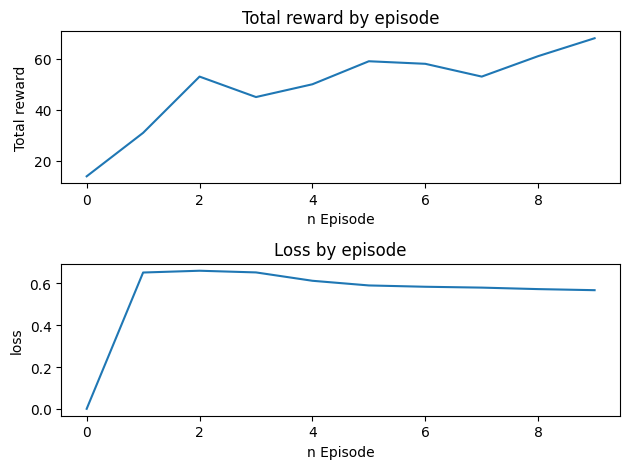

In [106]:
plt.figure(1)
plt.subplot(211)
plt.plot(np.arange(len(reward_chain)),reward_chain)
plt.title('Total reward by episode')
plt.xlabel('n Episode')
plt.ylabel('Total reward')

plt.subplot(212)
plt.plot(np.arange(len(loss_chain)),loss_chain)
plt.title('Loss by episode')
plt.xlabel('n Episode')
plt.ylabel('loss')
plt.tight_layout()
#plt.show()


if not os.path.exists('results'):
    os.makedirs('results')
    
plt.savefig('results/train_type_improved.eps', format='eps', dpi=1000)